### Unsupervised Analysis of Congressional Laws

In [1]:
import numpy as np
import pandas as pd
import itertools
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline


#gensim
from gensim import corpora, models, similarities, matutils

#sklearn
from sklearn.feature_extraction.text import (CountVectorizer, 
                                             TfidfTransformer,
                                             TfidfVectorizer)

In [2]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import (NMF,
                                   TruncatedSVD)
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE

In [3]:
laws_df = pd.read_csv('all_laws.csv',index_col=0)
paragraph_count_df = laws_df.applymap(lambda x: str.count(x, '\n\n')).reset_index()
paragraph_count_df.rename(columns={'index':'id','text':'paragraphs'},inplace=True)

In [4]:
laws_names = list(laws_df.index)
laws_list = laws_df['text'].tolist()

In [5]:
np.shape(laws_df)

(3896, 1)

__Import Law Summary Data__

In [6]:
laws_summaries = pd.read_csv('laws_summary.csv')

__ Import Custom Stop Words__

In [7]:
custom_stopwords_df = pd.read_csv('custom_stopwords_more.csv')
custom_sw = frozenset(custom_stopwords_df.iloc[:,1])

In [8]:
custom_sw

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'amended',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'ante',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'apr',
           'april',
           'are',
           'around',
           'as',
           'at',
           'aug',
           'august',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
         

## NMF

In [9]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),  
                                   stop_words = custom_sw, 
                                   token_pattern="\\b[a-z][a-z]{2,100}\\b",
                                   max_df = 0.90,
                                   min_df = 50)

In [10]:
dtm = vectorizer.fit_transform(laws_list) 
#pd.DataFrame(dtm.toarray(), index=laws_names, columns=vectorizer.get_feature_names()).head(10)

In [11]:
np.shape(dtm)

(3896, 16471)

In [74]:
num_groups = 35
nmf_model = NMF(num_groups,random_state=50)
dtm_nmf = nmf_model.fit_transform(dtm)
dtm_nmf = Normalizer(copy=False).fit_transform(dtm_nmf)

In [75]:
np.shape(nmf_model.components_)

(35, 16471)

In [76]:
np.shape(dtm_nmf)

(3896, 35)

In [77]:
features = vectorizer.get_feature_names()
print("These are the documents extracted from the data and their respective topics:")
print('')
#nmf.components_


num_words = 30
for topicidx, topic in enumerate(nmf_model.components_):
    
    print('Topic: ' + str(topicidx))
    print("Keywords: " + " ".join([features[i] for i in topic.argsort()[:-1*num_words-1:-1]]) )# 
    print('')

These are the documents extracted from the data and their respective topics:

Topic: 0
Keywords: office building post office building post facility service located facility united states postal postal service postal located building approved building law building enacted service designation facility designate facility facility referred states facility map regulation law map act designate building designation regulation document known designated record united document record shall known referred shall street

Topic: 1
Keywords: state secretary program assistance housing grant child eligible services shall school local children agency secretary shall educational programs funds grants development individuals education activities including care training percent entity described provide

Topic: 2
Keywords: courthouse states courthouse courthouse located courthouse law courthouse approved courthouse enacted courthouse referred street designate united designation united assembled designation 

__Investigate whether Topics identified match title__

In [78]:
def rank_df(df,rank,num_groups):
    coln = 'MAX' + str(rank) 
    sortID = np.argpartition(
        -df[list(np.arange(0,num_groups))].values,rank,axis=1)[:,rank-1]
    df[coln] = df.columns[sortID]

In [79]:
nmf_df = pd.DataFrame(dtm_nmf, index = laws_df.index)

rank_df(nmf_df,1,num_groups)
rank_df(nmf_df,2,num_groups)
rank_df(nmf_df,3,num_groups)
nmf_df.reset_index(inplace=True)
nmf_df.rename(columns={'index':'id'},inplace=True)

nmf_df = nmf_df.merge(laws_summaries[['id',
                                      'title',
                                      'sponsor_party',
                                      'sponsor_state',
                                      'sponsor',
                                      'congress','url'
                                     ]],on = 'id',how = 'left')

In [80]:
# Random View of Laws
pd.options.display.max_colwidth = 100
nmf_df[['id','title','MAX1','MAX2','MAX3']].iloc[
    np.random.choice(np.arange(0,len(laws_list)),
                     size = 10,
                     replace = False)]

,id,title,MAX1,MAX2,MAX3
631,c105publ368,H.R.4110 - Veterans Programs Enhancement Act of 1998 105th Congress (1997-1998),7,28,28
986,c107publ304,"H.R.3340 - To amend title 5, United States Code, to allow certain catch-up contributions to the ...",28,12,4
340,c105publ105,H.J.Res.92 - Alabama-Coosa-Tallapoosa River Basin Compact 105th Congress (1997-1...,18,10,19
884,c107publ212,H.R.309 - Guam Foreign Investment Equity Act 107th Congress (2001-2002),28,26,16
1309,c108publ256,H.R.3917 - To designate the facility of the United States Postal Service located at 695 Marconi ...,5,0,28
1911,c109publ35,"H.R.3332 - Surface Transportation Extension Act of 2005, Part III 109th Congress...",20,22,18
3039,c112publ172,H.R.4240 - Ambassador James R. Lilley and Congressman Stephen J. Solarz North Korea Human Rights...,33,17,32
2648,c111publ165,H.R.5146 - To provide that Members of Congress shall not receive a cost of living adjustment in ...,24,25,9
3121,c112publ246,H.R.3869 - To designate the facility of the United States Postal Service located at 600 East Cap...,0,5,4
3087,c112publ215,H.R.4014 - To amend the Federal Deposit Insurance Act with respect to information provided to th...,26,19,34


In [97]:
# See if Group 7 and Group are used in the same documents
nmf_df[
    ['id','title','MAX1','MAX2','MAX3']].loc[
        nmf_df['MAX1']==29,:]

,id,title,MAX1,MAX2,MAX3
4,c104publ102,S.1341 - Saddleback Mountain-Arizona Settlement Act of 1995 104th Congress (1995...,29,23,33
62,c104publ155,H.R.3525 - Church Arson Prevention Act of 1996 104th Congress (1995-1996),29,19,26
73,c104publ165,"H.R.701 - To authorize the Secretary of Agriculture to convey lands to the City of Rolla, Missou...",29,3,29
91,c104publ181,H.J.Res.166 - Granting the consent of Congress to the Mutual Aid Agreement between the city of B...,29,33,19
127,c104publ213,H.R.2982 - Carbon Hill National Fish Hatchery Conveyance Act 104th Congress (199...,29,27,16
129,c104publ215,H.R.3287 - Crawford National Fish Hatchery Conveyance Act 104th Congress (1995-1...,29,27,16
145,c104publ23,H.R.535 - Corning National Fish Hatchery Conveyance Act 104th Congress (1995-1996),29,27,1
156,c104publ24,H.R.584 - To direct the Secretary of the Interior to convey a fish hatchery to the State of Iowa...,29,27,1
167,c104publ25,H.R.614 - To direct the Secretary of the Interior to convey to the State of Minnesota the New Lo...,29,27,18
184,c104publ265,H.R.3546 - Walhalla National Fish Hatchery Conveyance Act 104th Congress (1995-1...,29,27,16


Ok. Its clear that some of these groups are very similar. Especially the ones related to the post office. Lets see if we can use AgglomeraGve Clustering to find a heirarchy of groups

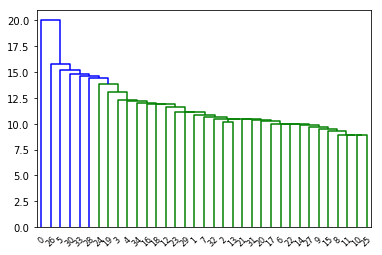

In [98]:
from scipy.cluster.hierarchy import dendrogram, linkage
data = [[0., 0.], [0.1, -0.1], [1., 1.], [1.1, 1.1]]
Z = linkage(dtm_nmf.transpose())
dendrogram(Z,labels=list(range(0,np.shape(dtm_nmf)[1]))) ; 

In [99]:
nmf_df.loc[1200:1205,['title','url']]

,title,url
1200,S.1824 - Overseas Private Investment Corporation Amendments Act of 2003 108th Co...,https://www.congress.gov/bill/108th-congress/senate-bill/1824/text
1201,H.R.2622 - Fair and Accurate Credit Transactions Act of 2003 108th Congress (200...,https://www.congress.gov/bill/108th-congress/house-bill/2622/text
1202,H.R.273 - Nutria Eradication and Control Act of 2003 108th Congress (2003-2004),https://www.congress.gov/bill/108th-congress/house-bill/273/text
1203,H.R.421 - Environmental Policy and Conflict Resolution Advancement Act of 2003 1...,https://www.congress.gov/bill/108th-congress/house-bill/421/text
1204,H.R.1367 - National Veterinary Medical Service Act 108th Congress (2003-2004),https://www.congress.gov/bill/108th-congress/house-bill/1367/text
1205,H.R.1821 - To award a congressional gold medal to Dr. Dorothy Height in recognition of her many ...,https://www.congress.gov/bill/108th-congress/house-bill/1821/text


## TSNE Visualization (NMF)

In [100]:
dtm_nmf2 = deepcopy(dtm_nmf)
np.argmax(dtm_nmf2,axis = 1) 

array([28, 28,  0, ..., 30, 34,  7])

In [85]:
tsne_model = TSNE(learning_rate=300,
                  perplexity=50,
                  early_exaggeration=4.0,
                  n_iter=5000,
                  verbose=2,
                  random_state = 50)

tsne_nmf = tsne_model.fit_transform(dtm_nmf)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3896
[t-SNE] Computed conditional probabilities for sample 2000 / 3896
[t-SNE] Computed conditional probabilities for sample 3000 / 3896
[t-SNE] Computed conditional probabilities for sample 3896 / 3896
[t-SNE] Mean sigma: 0.062712
[t-SNE] Iteration 25: error = 1.7341298, gradient norm = 0.0004030
[t-SNE] Iteration 25: gradient norm 0.000403. Finished.
[t-SNE] Iteration 50: error = 1.5544574, gradient norm = 0.0077978
[t-SNE] Iteration 75: error = 1.4376589, gradient norm = 0.0055946
[t-SNE] Iteration 100: error = 1.4130524, gradient norm = 0.0052592
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.413052
[t-SNE] Iteration 125: error = 1.2540565, gradient norm = 0.0035282
[t-SNE] Iteration 150: error = 1.2076691, gradient norm = 0.0031514
[t-SNE] Iteration 175: error = 1.1963279, gradient norm = 0.0030715
[t-SNE] Iteration 

Make Context Fields for Visualiztion

In [101]:
tsne_df = pd.DataFrame(tsne_nmf,columns=['tsne_x','tsne_y'])
tsne_df['robo_group'] = nmf_df['MAX1']
tsne_df['title'] = nmf_df['title']

In [102]:
tsne_df['title'] = tsne_df['title'].str.replace('\n',' ')
tsne_df['title'] = tsne_df['title'].str.replace('.','')
tsne_df['title'] = tsne_df['title'].str.replace('-','_')
tsne_df['title'] = tsne_df['title'].str.replace('[^a-zA-Z0-9\s\_]','')
tsne_df['title'] = tsne_df['title'].str.replace(' ','_')
tsne_df['title'] = tsne_df['title'].str.replace(r'(\_)\1+', r'\1')
tsne_df['title'] = tsne_df['title'].str.replace('_',' ')

In [103]:
tsne_df['paragraphs'] = np.log(paragraph_count_df['paragraphs'])

In [104]:
tsne_df['sponsor'] = nmf_df['sponsor']
tsne_df['url'] = nmf_df['url']

In [105]:
tsne_df

,tsne_x,tsne_y,robo_group,title,paragraphs,sponsor,url
0,1.217073,2.666668,28,S2 Congressional Accountability Act of 1995 104th Congress 1995 1996,5.627621,"Sen. Grassley, Chuck [R-IA]",https://www.congress.gov/bill/104th-congress/senate-bill/2/text
1,1.998022,4.931691,28,HR421 To amend the Alaska Native Claims Settlement Act to provide for the purchase of common sto...,3.091042,"Rep. Young, Don [R-AK-At Large]",https://www.congress.gov/bill/104th-congress/house-bill/421/text
2,2.054936,0.632403,0,HR1606 An Act to designate the United States Post Office building located at 24 Corliss Street P...,2.564949,"Rep. Reed, Jack [D-RI-2]",https://www.congress.gov/bill/104th-congress/house-bill/1606/text
3,-5.092594,-6.198420,13,HR2061 To designate the Federal building located at 1550 Dewey Avenue Baker City Oregon as the D...,2.639057,"Rep. Cooley, Wes [R-OR-2]",https://www.congress.gov/bill/104th-congress/house-bill/2061/text
4,-5.592561,-1.294015,29,S1341 Saddleback Mountain Arizona Settlement Act of 1995 104th Congress 1995 1996,3.555348,"Sen. McCain, John [R-AZ]",https://www.congress.gov/bill/104th-congress/senate-bill/1341/text
5,1.558419,-2.920234,34,HR2924 To guarantee the timely payment of social security benefits in March 1996 104th Congress ...,2.564949,"Rep. Archer, Bill [R-TX-7]",https://www.congress.gov/bill/104th-congress/house-bill/2924/text
6,-2.282478,-2.856751,10,S652 Telecommunications Act of 1996 104th Congress 1995 1996,6.345636,"Sen. Pressler, Larry [R-SD]",https://www.congress.gov/bill/104th-congress/senate-bill/652/text
7,1.774781,4.814930,28,HR2029 Farm Credit System Reform Act of 1996 104th Congress 1995 1996,5.236442,"Rep. Allard, Wayne [R-CO-4]",https://www.congress.gov/bill/104th-congress/house-bill/2029/text
8,2.547598,2.262138,14,S1124 National Defense Authorization Act for Fiscal Year 1996 104th Congress 1995 1996,8.232972,"Sen. Thurmond, Strom [R-SC]",https://www.congress.gov/bill/104th-congress/senate-bill/1124/text
9,4.357696,3.257769,33,HR1868 Foreign Operations Export Financing and Related Programs Appropriations Act 1996 104th Co...,6.139885,"Rep. Callahan, Sonny [R-AL-1]",https://www.congress.gov/bill/104th-congress/house-bill/1868/text


In [109]:
d3names_df = pd.read_csv('D3LabelNames.csv',header=1)

In [110]:
d3names_df = d3names_df.iloc[0:35,1:]
d3names_df['robo_group'] = d3names_df['Topic Number'].apply(int)
d3names_df.set_index('robo_group', inplace = True)
d3names_df_mini = d3names_df['Macro Name']
d3_dict = d3names_df_mini.to_dict()

In [111]:
d3_dict

{0: 'Government Buildings',
 1: 'Pub and Env Safety',
 2: 'Government Buildings',
 3: 'Federal Land and Wildlife',
 4: 'Government Spending',
 5: 'Government Buildings',
 6: 'Government Spending',
 7: 'Veterans',
 8: 'Infrastructure',
 9: 'Education',
 10: 'Bureaucracy',
 11: 'Commemorative Coins',
 12: 'Health Care',
 13: 'Government Buildings',
 14: 'National Security',
 15: 'Small Businesses',
 16: 'National Parks and Monuments',
 17: 'Veterans',
 18: 'Infrastructure',
 19: 'Human Rights',
 20: 'Infrastructure',
 21: 'District of Columbia',
 22: 'Education',
 23: 'Native Americans',
 24: 'Government Spending',
 25: 'Veterans',
 26: 'Bureaucracy',
 27: 'Federal Land and Wildlife',
 28: 'Taxes',
 29: 'Federal Land and Wildlife',
 30: 'National Security',
 31: 'Pub and Env Safety',
 32: 'National Parks and Monuments',
 33: 'Foreign Relations',
 34: 'National Security'}

Make "Key Words" Section

In [112]:
dtm_dense = dtm.todense()

num_kw = 5
key_words = []
for ix in range(0,np.shape(dtm_dense)[0]):
    imp_words_idx = np.argpartition(dtm_dense[ix,:], -num_kw)[0,-num_kw:].tolist()[0]
    key_words.append(' | '.join([features[w] for w in imp_words_idx]))

In [113]:
kw_df = pd.DataFrame(key_words,columns=['key words'])

kw_df['key words'] = kw_df['key words'].apply(str)

tsne_df['key_words'] = kw_df

tsne_df['robo_group_names'] = tsne_df['robo_group'] 

tsne_df['robo_group_names'] = tsne_df['robo_group_names'].map(d3_dict)

tsne_df['robo_group'].unique()

array([28,  0, 13, 29, 34, 10, 14, 33, 23, 16,  7, 17,  2, 30,  6, 18,  1,
       15,  4,  3, 31, 26, 19, 22, 27, 12, 24, 32, 21,  8,  5, 25,  9, 11,
       20])

In [114]:
tsne_df.to_csv('tsne_data_attempt7.csv',index=None)

In [115]:
tsne_df['robo_group_names'].unique()

array(['Taxes', 'Government Buildings', 'Federal Land and Wildlife',
       'National Security', 'Bureaucracy', 'Foreign Relations',
       'Native Americans', 'National Parks and Monuments', 'Veterans',
       'Government Spending', 'Infrastructure', 'Pub and Env Safety',
       'Small Businesses', 'Human Rights', 'Education', 'Health Care',
       'District of Columbia', 'Commemorative Coins'], dtype=object)

Color by Topic

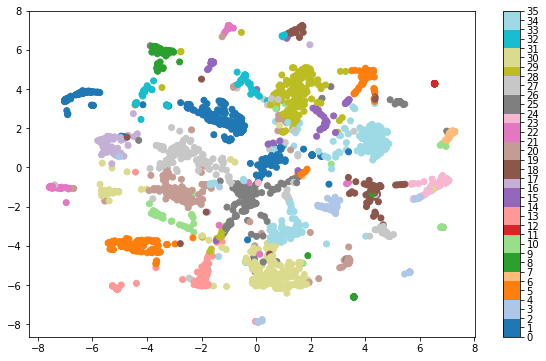

In [116]:
plt.figure(figsize=(10,6))
plt.scatter(tsne_nmf[:,0], 
            tsne_nmf[:,1], 
            c=nmf_df.MAX1, 
            cmap=plt.cm.get_cmap("tab20", num_groups))
plt.colorbar(ticks=range(num_groups+1))
plt.clim(0, num_groups)
plt.show()

Color by Party

In [117]:
c_bar_party = nmf_df['sponsor_party']

m_dict = {'D':0,'R':1}
c_bar_party = c_bar_party.map(m_dict)

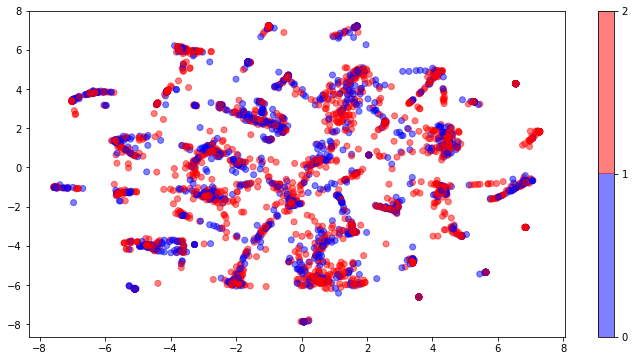

In [118]:
plt.figure(figsize=(12,6))
plt.scatter(tsne_nmf[:,0], 
            tsne_nmf[:,1], 
            c=c_bar_party, 
            cmap=plt.cm.get_cmap("bwr", 2),
           alpha = 0.5)
plt.colorbar(ticks=range(2+1))
plt.clim(0, 2)
plt.show()

Color by state of sponsoring congress person

In [119]:
states = laws_summaries['sponsor_state'].unique()

states_dict = dict()
for ix, s in enumerate(states):
    states_dict[s] = ix
    
num_states = ix + 1

c_bar_state = nmf_df['sponsor_state']
c_bar_state = c_bar_state.map(states_dict)

states_df = pd.DataFrame(list(states_dict.items()),columns=['states','num'])

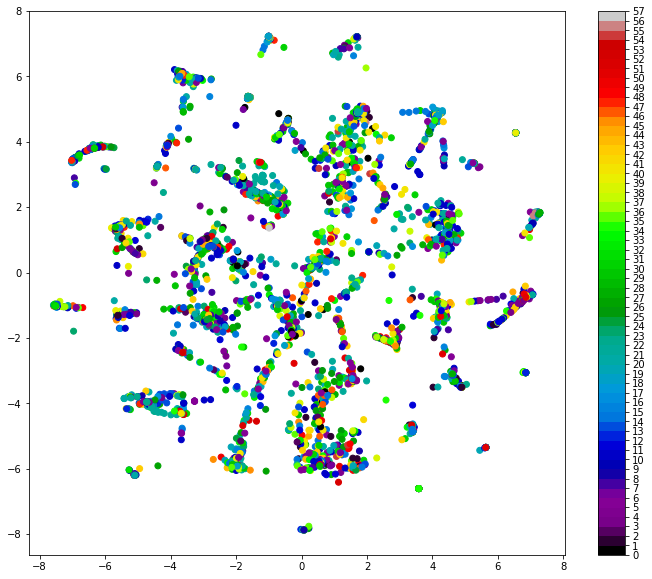

<function matplotlib.pyplot.colorbar>

In [120]:
plt.figure(figsize=(12,10))
plt.scatter(tsne_nmf[:,0],
            tsne_nmf[:,1], 
            c=c_bar_state, 
            cmap=plt.cm.get_cmap("nipy_spectral", num_states))
plt.colorbar(ticks=range(num_states+1))
plt.clim(0, num_states)
plt.show()

plt.colorbar

Color by congressional sessions chronologically

In [45]:
congress = laws_summaries['congress'].unique()

congress_dict = dict()
for ix, c in enumerate(congress):
    congress_dict[c] = ix
    
num_congress = ix + 1

c_bar_congress = nmf_df['congress']
c_bar_congress = c_bar_congress.map(congress_dict)

congress_df = pd.DataFrame(list(congress_dict.items()),columns=['congress','num'])

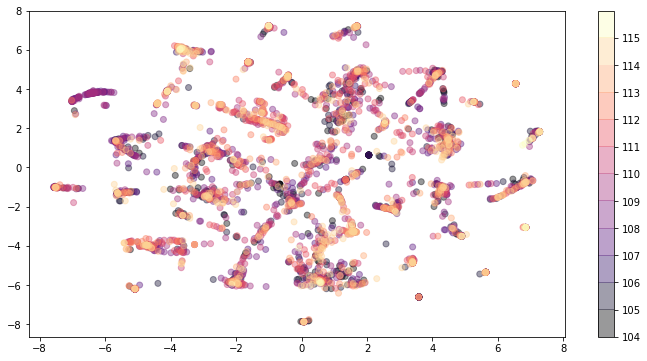

In [143]:
plt.figure(figsize=(12,6))
plt.scatter(tsne_nmf[:,0],
            tsne_nmf[:,1], 
            c=c_bar_congress, 
            cmap=plt.cm.get_cmap("magma", num_congress),
            alpha = 0.4)
cb = plt.colorbar(ticks=range(num_congress))
plt.clim(0, num_congress)

cb.set_ticklabels(np.arange(104,116))

In [153]:
tsne_df.groupby('robo_group_names').count()

,tsne_x,tsne_y,robo_group,title,paragraphs,sponsor,url,key_words
robo_group_names,,,,,,,,
Bureaucracy,269,269,269,268,269,268,268,269
Commemorative Coins,46,46,46,46,46,46,46,46
District of Columbia,76,76,76,76,76,76,76,76
Education,105,105,105,105,105,105,105,105
Federal Land and Wildlife,270,270,270,267,270,267,267,270
Foreign Relations,200,200,200,197,200,197,197,200
Government Buildings,700,700,700,696,700,696,696,700
Government Spending,366,366,366,363,366,363,363,366
Health Care,113,113,113,112,113,112,112,113
